## PageRank

This notebook creates a graph from the entities and relations obtained from tweets and runs the PageRank algorithm to determine the most important nodes in the resulting graph.

In [1]:
from functools import reduce
from pyspark.sql.functions import col, lit, when, desc
from graphframes import *

from pyspark.sql import SparkSession

from nltk.corpus import stopwords
import string

In [2]:
database = "analysisDB"
collection = "covid_vertices"
collection_2 = "covid_edges"
topic = "covid" # covid | blm

In [3]:
spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri=mongodb://mongo:27017/"+database+"."+collection) \
    .config("spark.mongodb.output.uri=mongodb://mongo:27017/"+database+"."+collection) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.3.2') \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
vert_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://mongo:27017/"+database+"."+collection).load()
vert_df.columns

['_id', 'vertex']

In [5]:
spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri=mongodb://mongo:27017/"+database+"."+collection_2) \
    .config("spark.mongodb.output.uri=mongodb://mongo:27017/"+database+"."+collection_2) \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.3.2') \
    .getOrCreate()

sc = spark.sparkContext

In [6]:
edge_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("uri","mongodb://mongo:27017/"+database+"."+collection_2).load()
edge_df.columns

['_id', 'edge']

In [7]:
edge_list = [tuple(i.edge) for i in edge_df.select('edge').distinct().collect()]
edge_list[:5]

vert_list = [tuple(i.vertex) for i in vert_df.select('vertex').distinct().collect()]
vert_list[:5]

[('important', 'important'),
 ('expert speakers', 'expert speakers'),
 ('keeping', 'keeping'),
 ('covid19 recovery', 'covid19 recovery'),
 ('march against injustice', 'march against injustice')]

In [8]:
# Create graph
vertices = spark.createDataFrame(vert_list, ["id", "text"])
edges = spark.createDataFrame(edge_list, ["src", "dst", "relationship"])

g = GraphFrame(vertices, edges)
g.vertices.show()

+--------------------+--------------------+
|                  id|                text|
+--------------------+--------------------+
|           important|           important|
|     expert speakers|     expert speakers|
|             keeping|             keeping|
|    covid19 recovery|    covid19 recovery|
|march against inj...|march against inj...|
|for family carers...|for family carers...|
|     crucial program|     crucial program|
|        @smritikiran|        @smritikiran|
|@iffr https://t.c...|@iffr https://t.c...|
|will soon persona...|will soon persona...|
|her story so comp...|her story so comp...|
|our current reali...|our current reali...|
|                many|                many|
|new @ncbi sars-co...|new @ncbi sars-co...|
|       six new cases|       six new cases|
|           solutions|           solutions|
|               fight|               fight|
|        shortly givi|        shortly givi|
|                   r|                   r|
|link in context o...|link in co

In [9]:
# Run PageRank
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank")\
    .join(vertices, on="id").orderBy("pagerank", ascending=False)\
    .show(10)

+-----------+------------------+-----------+
|         id|          pagerank|       text|
+-----------+------------------+-----------+
|      clear|1902.3859138997075|      clear|
|     enough|1891.0006989751973|     enough|
|    covid19|1254.2154049726319|    covid19|
|         us| 647.2511877541159|         us|
|         it|501.76233930237595|         it|
|        you|492.36492228871646|        you|
|      today|476.23761894085965|      today|
|    garbage|415.20505519831033|    garbage|
|coronavirus|359.31812975944996|coronavirus|
|      world|282.94364253589947|      world|
+-----------+------------------+-----------+
only showing top 10 rows



In [10]:
page_rank_df = results.vertices.select("id", "pagerank").join(vertices, on="id").orderBy("pagerank", ascending=False).limit(25).toPandas()

In [11]:
#remove stopwords from top 25 nodes

to_drop_list = []

for index, row in page_rank_df.iterrows():
    if row['text'] in stopwords.words('english'):
        to_drop_list.append(index)

page_rank_df = page_rank_df.drop(to_drop_list)     
len(page_rank_df.index)

20

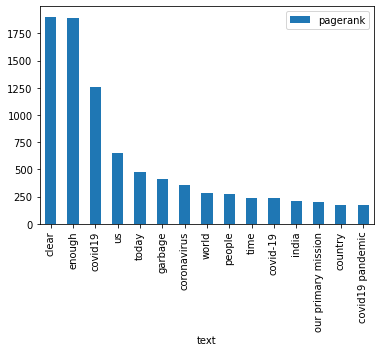

In [14]:
# plot 15 nodes with highest pagerank score
page_rank_df[:15].plot.bar(x='text', y='pagerank', rot=90)